In [2]:
# Install libraries

# %pip install torch torchvision matplotlib pillow numpy

import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import Tuple, Dict
from collections import defaultdict
from PIL import Image
import time


In [17]:
print(torch.cuda.is_available())   # CUDA Availability: False

False


In [3]:
# Setting up train, test folders paths

train_dataset = "./Intel_Image_Classification/train_segment/originals"
test_dataset  = "./Intel_Image_Classification/test_segment"

In [18]:
# Figguring out (height, width, imager/class, format) of images from either training or testing sets

def get_info_from_data_set(path: str) -> Tuple[int, int, Dict[str, int], Dict[str, int]]:
    heights = []
    widths  = []
    formats = defaultdict()
    images_per_class = dict()

    for image_class in os.listdir(path):
        image_class_dir = os.path.join(path, image_class)
        class_images    = os.listdir(image_class_dir)

        images_per_class[image_class] = len(class_images)

        for image in class_images:
            image_path     = os.path.join(image_class_dir, image)
            image_as_array = np.array(Image.open(image_path))
            
            h, w, c = image_as_array.shape

            heights.append(h)
            widths.append(w) 

            image_name, image_extension = os.path.splitext(image_path)

            if image_extension not in formats.keys():
                formats[image_extension] = 0
            else:
                formats[image_extension] += 1
            

    average_height = sum(heights) / len(heights)
    average_wifth  = sum(widths) / len(widths)

    return (round(average_height), round(average_wifth), images_per_class, formats)

In [19]:
(average_img_h, average_img_w, images_per_class, formats) = get_info_from_data_set(train_dataset)
print(f'average_height:   {average_img_h}')
print(f'average_width:    {average_img_w}')
print(f'formats:          {formats}')
print(f'images_per_class: {images_per_class}')

average_height:   150
average_width:    150
formats:          defaultdict(None, {'.jpg': 14033})
images_per_class: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


In [30]:
# Creating training, testing datasets from the local dir
# Creating an iterator over random batches (DataLoader) 

# Set of transforms to be aplied
transform = v2.Compose([
    v2.ToImage(),       
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),              
    v2.Resize(size=(round(average_img_h), round(average_img_w)))  
])

# Creating train, test sets from folder in root path
train_set = torchvision.datasets.ImageFolder(root=train_dataset, transform=transform)
test_set  = torchvision.datasets.ImageFolder(root=test_dataset,  transform=transform)

# Creating iterable dataloders
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=16,  shuffle=True)

print(f'batches_in_train_dataloader: {len(train_dataloader)}')
print(f'batches_in_test_dataloader:  {len(test_dataloader)}')

batches_in_train_dataloader: 878
batches_in_test_dataloader:  188


In [21]:
# Getting numeric, alpabetical labels from the dataset

labels_numbers_to_strings = {val: key for key, val in train_dataloader.dataset.class_to_idx.items()}
labels_strings_to_numbers = train_dataloader.dataset.class_to_idx

print(f'labels_numbers_to_strings: {labels_numbers_to_strings}')
print(f'labels_strings_to_numbers: {labels_strings_to_numbers}')

labels_numbers_to_strings: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
labels_strings_to_numbers: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


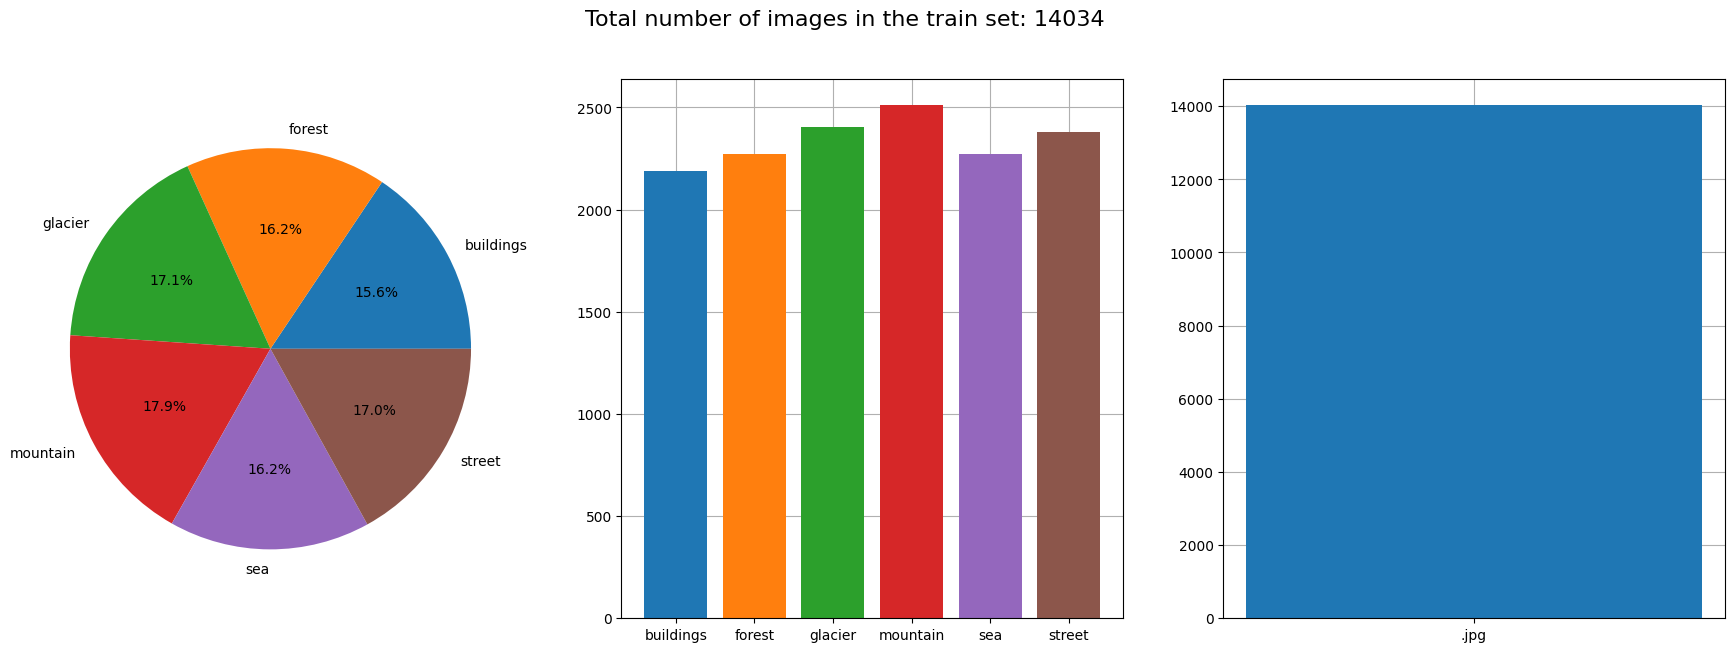

In [22]:
# Creating plots (1 row of 3 plots)
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

# Creating a pie
wedges, texts, autotext = ax[0].pie(
    x      = list(images_per_class.values()), 
    labels = list(images_per_class.keys()) ,  
    autopct= lambda pct: f'{pct:.1f}%'
    ) 

# Remembering pie colors to use on the next plot
pie_colors = [wedge.get_facecolor() for wedge in wedges]

# Creating a bar plot for image/class distribution
ax[1].bar(
    images_per_class.keys(), 
    images_per_class.values(), 
    color  = pie_colors,
    zorder = 2
    )   
ax[1].grid()

# Creating a bar plot for img type distribution
ax[2].bar(
    formats.keys(), 
    formats.values(), 
    zorder = 2
    ) 
ax[2].grid()

fig.suptitle(f'Total number of images in the train set: {sum(images_per_class.values())}', fontsize=16)

plt.show()

In [23]:
# Used for displaying multiple images on a single pyplot
def print_images(images_as_vectors, labels_strings=None, labels_numeric=None):
    if labels_strings != None and labels_numeric != None:
        raise ValueError('Optional labels_strings, labels_numeric cannot both be set, use 1 of them')   
    
    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_strings supposed to have the same size")

    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_numeric supposed to have the same size")
    
    # Create a single plot for multiple images (one subplot per image)
    # The number of columns in the plot is determined by the number of images to display
    fig, axes = plt.subplots(ncols=len(images_as_vectors), figsize=(20, 20))

    # Setting up labels for images
    labels = [''] * len(images_as_vectors)
    if labels_strings != None:
        labels = labels_strings
    elif labels_numeric != None:
        labels = [labels_numbers_to_strings[int(i)] for i in labels_numeric]

    # Plotting images
    for index, image_as_vector in enumerate(images_as_vectors):

        # image_as_vector is expected to have shape of [chanels, h, w], since it is from datLoader
        # Pyplot expects images to have rgb chanels in the last dimention, so transpose
        image_as_vector = np.transpose(image_as_vector, (1, 2, 0))

        # If 1 image is passed, creating subplots of length 1 will create a normal subplot
        # It wont be subscriptable, so it [] is used on it, i will result in a crash
        # So need a separate if
        if len(images_as_vectors) == 1:
            fig.set_size_inches(3, 3)

            # Plotting the image
            axes.imshow(image_as_vector)
            axes.title.set_text(labels[index])
            axes.title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes.set_xticks([])
            axes.set_yticks([])
        else:
            # Plotting the image
            axes[index].imshow(image_as_vector)
            axes[index].title.set_text(labels[index])
            axes[index].title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes[index].set_xticks([])
            axes[index].set_yticks([])
    
    plt.show()

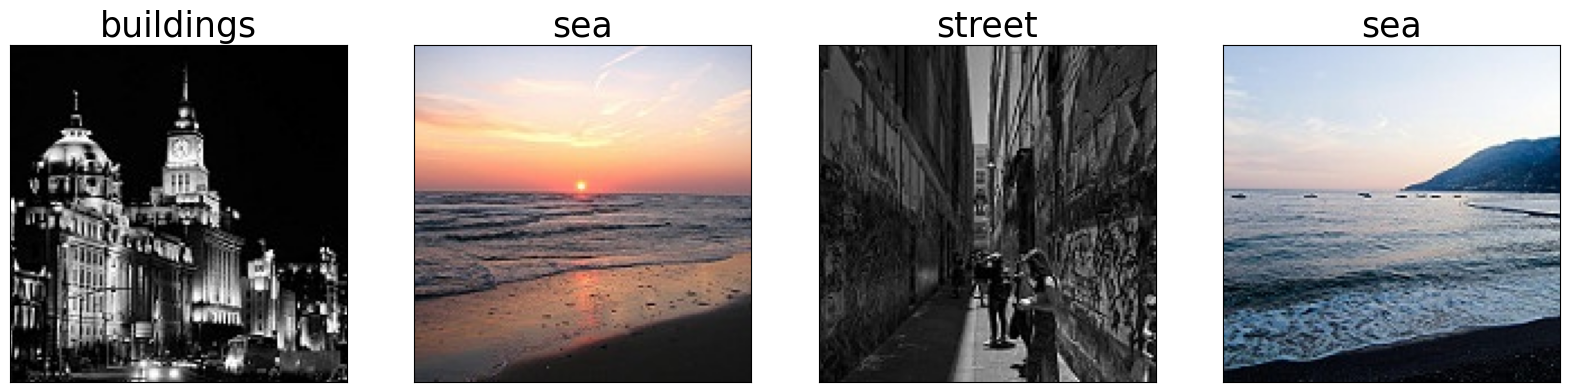

In [24]:
# Displaying some of the augmented images

first_batch = next(iter(train_dataloader))
first_batch_images         = first_batch[0]
first_batch_labels_numeric = first_batch[1]

print_images(first_batch_images[:4], labels_numeric=first_batch_labels_numeric)

In [25]:
# ======================================================================================================================================================================================
# ======================================================================================================================================================================================
# ======================================================================================================================================================================================

In [ ]:
# self.conv1  = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#   Transforming 3-channeled image into 6 conv maps, therefor into 6 chanels. Each convolution window if 5x5
#   In other words:
#       applying 6 filters on a rgb image

# self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)
#   Received 6 concolutions form conv1, apllying 2x2 pooling on them
#   In the end have 6 convolutions but kinda lossly compressed (pooled)

# self.conv2  = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#   Same as conv1, but 6 layers in after conv1 and pool1, and 16 out.


# self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2)
#   Same as pool1, but now working on 16 layers

# self.fc1    = nn.Linear(in_features=16*34*34, out_features=120)
#   Fully connected layer
#   We receive a vector of 16 * 34 * 34, why: 
#       1. 16 is the number of layes 
#       2. 34 x 34 is the size of a single conv to whitch eatch image was transofrmed after conv1, pool1 ...
#       3. 16 is the number of those convs for each image. So 1 iamge, if displayed as a vector, would have 16 * 34 * 34 dims
 

# self.fc2    = nn.Linear(in_features=120, out_features=84)
# self.fc3    = nn.Linear(in_features=84, out_features=len(labels_numbers_to_strings))
#   These 2 are just reducing the vectors, until a vector if shape len(labels_numbers_to_strings) is reached.
#   That vector represent end values for each class 

# ==============================================================================================================================

# def forward(self, inputs):
#     inputs is a tensor of shape (batch_size, c, h, w)

#     inputs = self.pool1(F.relu(self.conv1(inputs)))   <- first layer
#     inputs = self.pool2(F.relu(self.conv2(inputs)))   <- second layer

#     inputs = torch.flatten(inputs, 1) 
#       Since inputs is a batch, we only flatten each image representation of newly created convlotions 

#     inputs = F.relu(self.fc1(inputs))     <- fullt connected 1
#     inputs = F.relu(self.fc2(inputs))     <- fullt connected 2
#     inputs = self.fc3(inputs)             <- fullt connected 3
#     return inputs

In [26]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1  = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2  = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1    = nn.Linear(in_features=16*34*34, out_features=120)
        self.fc2    = nn.Linear(in_features=120, out_features=84)
        self.fc3    = nn.Linear(in_features=84, out_features=len(labels_numbers_to_strings))

    def forward(self, inputs):
        inputs = self.pool1(F.relu(self.conv1(inputs)))
        inputs = self.pool2(F.relu(self.conv2(inputs)))
        inputs = torch.flatten(inputs, 1) # flatten all dimensions except batch
        inputs = F.relu(self.fc1(inputs))
        inputs = F.relu(self.fc2(inputs))
        inputs = self.fc3(inputs)
        return inputs


In [31]:
model = CNN_Model()

loss_function = nn.CrossEntropyLoss()
optimizer     = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 40
epoch_losses     = []       # Stores the loss values for each epoch, later used for plotting the progression
epoch_accuracies = []       # Stores the accuracy values for each epoch, later used for plotting the progression

# Using these for logging  
epoch_start_time    = 0     
model_training_time = 0    

print("[epoch, average_batch_loss, batch_accuracy, batch_time_spent, total_time_spent]")

for epoch in range(n_epochs):
    epoch_start_time = time.time()
    
    # These to track performance during each epoch
    training_loss       = 0.0
    correct_predictions = 0
    total_samples       = 0
    total_batches       = len(train_dataloader)

    for inputs, labels in train_dataloader:

        # Zero the parameter gradients (Reson for it: https://medium.com/@lazyprogrammerofficial/in-pytorch-why-do-we-need-to-call-optimizer-zero-grad-8e19fdc1ad2f#:~:text=zero_grad()%20method%20is%20used,respect%20to%20the%20model%20parameters.)
        optimizer.zero_grad()

        # Outputs -> Tensor.shape = (batch_size, number_of_possible_classes)
        outputs = model(inputs)

        # Loss, Backpropogation, Optimization
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accesing loss value and storing it
        training_loss += loss.item()
        
        # Calculating accuracy
        # Getting index for each max vector value inside a batch 
        max_values, indexes_of_max = torch.max(outputs, 1)   

        # NOTE: add softmax for clarity

        # Getting stats
        correct_predictions += (indexes_of_max == labels).sum().item()
        total_samples += len(labels) 
        
        # Note: 
            # (indexes_of_max == labels) is not a regular list == operator
            # Since those are torch.Tensor they have a different == operator
            # It compares each element of 2 tensors of the same size and returns a new tensor of bool values
            # e.g: [1,2,3] == [1,2,1] -> [True, True, False]
            # kinda like list( map( lambda x: x[0] == x[1], zip(indexes_of_max, labels) ) )
            # (indexes_of_max == labels).sum() calculates number of True values, returns Tensor(value)
            # (indexes_of_max == labels).sum().item() access the value wrapped into a Tensor

    # Evaluating the previos epoch
    average_loss = training_loss / total_batches
    accuracy     = 100 * correct_predictions / total_samples

    # Storing results of the previous epoch
    epoch_losses.append(average_loss)
    epoch_accuracies.append(accuracy)

    # Logging time spent on the previous epoch
    epoch_time_spent_min = (time.time() - epoch_start_time) / 60
    model_training_time  += epoch_time_spent_min

    print(f'[{epoch + 1}/{n_epochs}, {average_loss:.4f}, {accuracy:.4f}, {epoch_time_spent_min:.1f} min, {model_training_time:.1f} min]')
    
print('Done Training')




[epoch, average_batch_loss, batch_accuracy, batch_time_spent, total_time_spent]
[1/40, 1.3441, 44.9266, 0.3 min, 0.3 min]
[2/40, 1.0037, 60.1397, 0.3 min, 0.6 min]
[3/40, 0.9396, 63.1751, 0.3 min, 1.0 min]
[4/40, 0.8644, 66.6168, 0.3 min, 1.3 min]
[5/40, 0.7878, 69.7948, 0.3 min, 1.6 min]
[6/40, 0.7119, 72.8588, 0.3 min, 1.9 min]
[7/40, 0.6680, 74.7755, 0.3 min, 2.2 min]
[8/40, 0.6212, 76.9417, 0.3 min, 2.6 min]
[9/40, 0.5681, 78.8015, 0.3 min, 2.9 min]
[10/40, 0.5204, 80.7254, 0.3 min, 3.2 min]
[11/40, 0.4818, 82.1149, 0.3 min, 3.5 min]
[12/40, 0.4410, 83.6540, 0.3 min, 3.9 min]
[13/40, 0.3915, 85.6206, 0.3 min, 4.2 min]
[14/40, 0.3503, 87.6372, 0.3 min, 4.5 min]
[15/40, 0.3107, 88.6917, 0.3 min, 4.9 min]
[16/40, 0.2803, 89.9886, 0.3 min, 5.2 min]
[17/40, 0.2343, 91.6204, 0.3 min, 5.5 min]
[18/40, 0.2014, 92.9956, 0.3 min, 5.8 min]
[19/40, 0.1714, 93.8649, 0.3 min, 6.1 min]
[20/40, 0.1526, 94.9409, 0.3 min, 6.5 min]
[21/40, 0.1280, 95.6819, 0.3 min, 6.8 min]
[22/40, 0.1250, 95.8672, 0

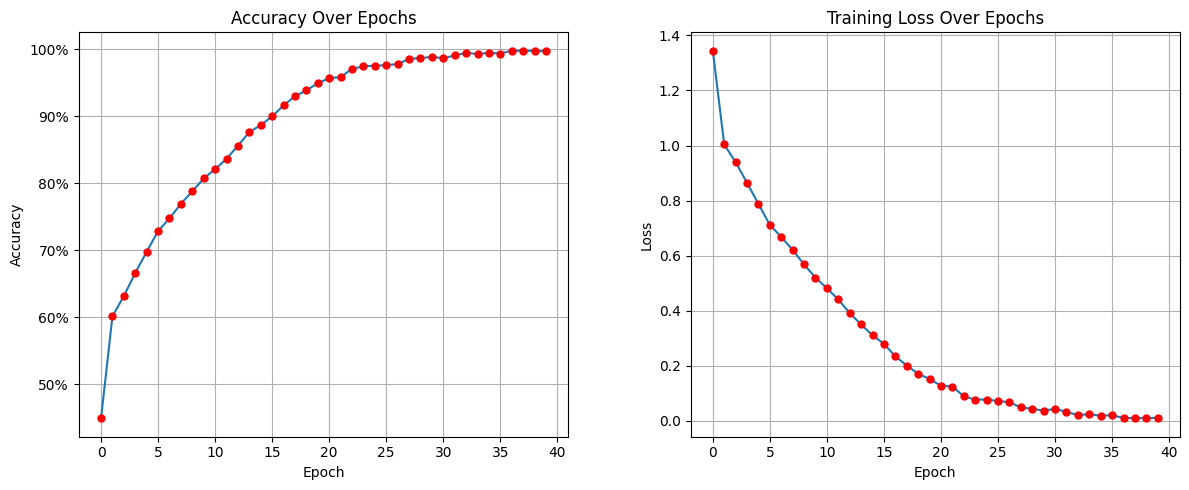

In [32]:
# Displaying usefull training info

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 

# Plotting the first graph (Accuracy)
ax[0].plot(range(n_epochs), epoch_accuracies, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0].set_title("Accuracy Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].yaxis.set_major_formatter(lambda x, pos: f'{int(x)}%')
ax[0].grid()

# Plotting the second graph (Loss)
ax[1].plot(range(n_epochs), epoch_losses, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[1].set_title("Training Loss Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].grid()

# Adjusting layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

plt.show()

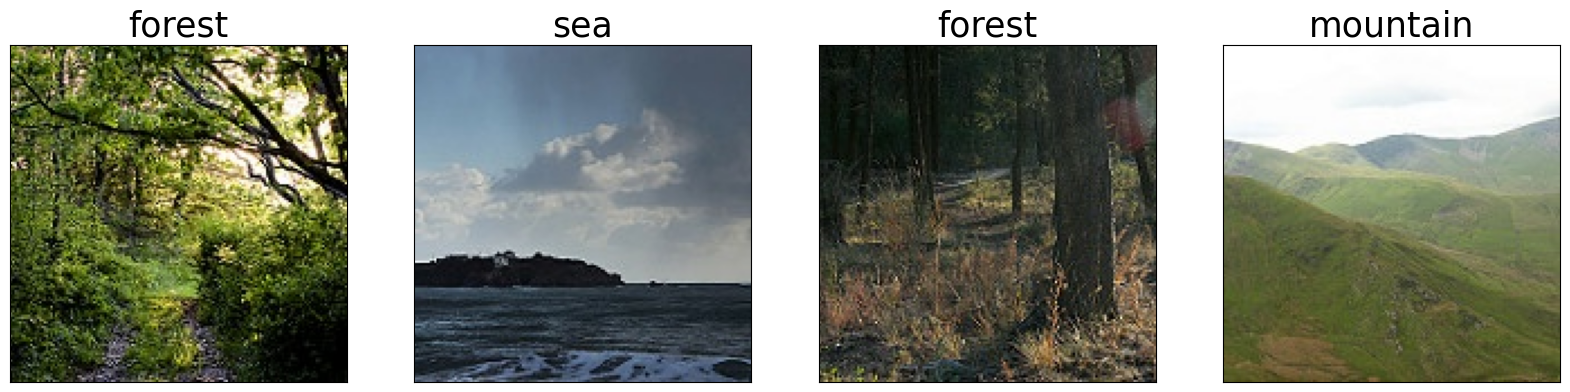

In [33]:
# Visualising a couple of images from the testing set

testing_batch = next(iter(test_dataloader))

testing_batch_images = testing_batch[0]
testing_batch_labels = testing_batch[1]

print_images(testing_batch_images[:4], labels_numeric=testing_batch_labels[:4])

In [142]:
# Testing the model on the testing set, calculating accuracy

def test_model(dataloader: DataLoader) -> Tuple[Dict[str, int], Dict[str, int]]:
    each_class_correct_predictions  = {label: 0 for label in labels_numbers_to_strings.keys()}
    each_class_occurance = {label: 0 for label in labels_numbers_to_strings.keys()}

    model_testing_time = 0

    print("[epoch, accuracy, total_time_spent]")

    epoch_start_time = time.time()

    correct_predictions = 0
    total_predictions   = 0

    for inputs, labels in dataloader:
        # Getiing a prediction
        batch_predictions = model(inputs)

        # Getting a predicted class for each input
        max_values, max_indices = torch.max(batch_predictions, 1)

        # Comparing predictions to the golden labels
        correct_predictions += (max_indices == labels).sum().item()
        total_predictions   += len(labels)
    
        for i in range(len(labels)):  # Looping through each label in the batch
            label = labels[i].item()
            prediction = max_indices[i].item()
            each_class_correct_predictions[label] += (prediction == label)
            each_class_occurance[label] += 1

    accuracy = 100 * correct_predictions / total_predictions

    epoch_time_spent_sec = (time.time() - epoch_start_time) / 60
    model_testing_time   += epoch_time_spent_sec

    print(f'[{epoch + 1}/{n_epochs}, {accuracy:.4f}, {model_testing_time:.1f} min]')
    return (each_class_correct_predictions, each_class_occurance)

(each_class_correct_predictions, each_class_occurance) = test_model(test_dataloader)

[epoch, accuracy, total_time_spent]
[40/40, 77.5667, 0.0 min]


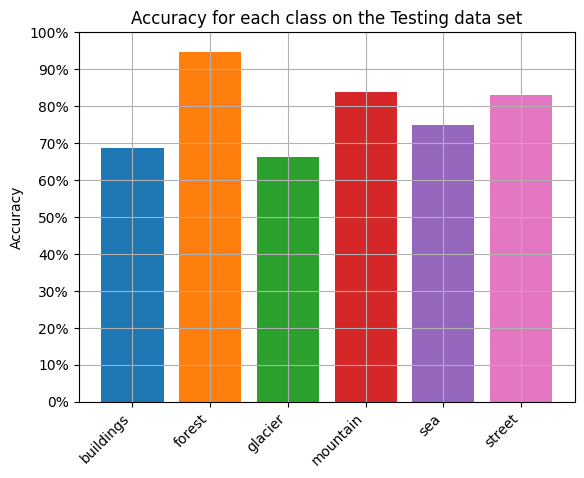

In [36]:
# Asserting 
if len(each_class_correct_predictions.values()) != len(each_class_occurance.values()):
    raise ValueError('Something happend to the labels')

fig, ax = plt.subplots()
classes   = labels_strings_to_numbers.keys()

# Calculating accuracy for each class
each_class_accuracy = []
for i in range(len(classes)):
    class_i_accuracy = (each_class_correct_predictions[i] / each_class_occurance[i])
    each_class_accuracy.append(class_i_accuracy)

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#e377c2",  # Pink   
]

# Plotting
ax.bar(classes, each_class_accuracy, color=colors)
ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy for each class on the {"Testing data set"}')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_major_formatter(lambda x, pos: f'{int(x * 100)}%')
ax.grid()

plt.xticks(rotation=45, ha='right')
plt.show()

In [207]:
# Manually testing on a random pictures from the training set

def test_on_a_random_picture(model: CNN_Model, dataloader: DataLoader):
    # Getting a random image
    random_test_batch = next(iter(dataloader))
    random_test_image   = random_test_batch[0][0]

    # Getting a string label for a random image from a numeric stored inside the batch
    random_test_image_label_numeric = random_test_batch[1][0].item()
    random_test_image_label_string  = labels_numbers_to_strings[random_test_image_label_numeric]

    # Image is of shape (3, 150, 150), since model takes in batched of shape (batch_size, 3, 150, 150)
    # we need to make it at least (1, 3, 150, 150), unsqueeze(0) does that
    prediction_vector = model(random_test_image.unsqueeze(0))
    prediction_max_value, prediction_index = torch.max(prediction_vector, 1)
    predicted_class   = labels_numbers_to_strings[prediction_index.item()]
    
    print(f'Predicted class: {predicted_class}')
    print(f'Actual class:    {random_test_image_label_string}')
    print_images([random_test_image], [predicted_class])
   

Predicted class: mountain
Actual class:    mountain


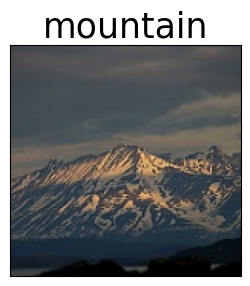

In [213]:
test_on_a_random_picture(model, test_dataloader)

In [ ]:
# TODO: maybe add recall, dont know if i need to, seems like accurasy is the most important thing for this type of classification

In [214]:
torch.save(model, 'model.pth')

In [216]:
model = torch.load('model.pth', weights_only=False)

In [217]:
model

CNN_Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)